## Identifying fraudulent transactions using DBSCAN
DBSCAN groups together points that are closely packed and marks points that lie alone in low-density regions as outliers. 

In [23]:
import pandas as pd 

df = pd.read_csv("creditcard.csv")

target_feature = "Class"
input_features = list(df.columns)
input_features.remove(target_feature)

print(f"Target Variable: {target_feature}")
print(f"Input Variables: {input_features}")

Target Variable: Class
Input Variables: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


## Feature Engineering

Consider:
- Should we scale our features?
- What features should we include?
    ALL OF THEM



## Train a DBSCAN model
DBSCAN groups together points that are closely packed and marks points that lie alone in low-density regions as outliers. 
DBSCAN is effective for identifying clusters of varying shapes and sizes in data with noise. It is particularly useful for detecting outliers and anomalies as noise points.

- [Scikit Learn - DBSCAN documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
- [Scikit Learn - Demo of DBSCAN clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
- [Scikit Learn - DBSCAN User Guide](https://scikit-learn.org/stable/modules/clustering.html#dbscan)


In [39]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Split the data into features 'X' and target 'y'
X = df[input_features]
y = df[target_feature]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train and fit model
dbscan = DBSCAN(
    # eps = .5,
    # min_samples = 5
    ).fit(X_train_scaled)

labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1983
Estimated number of noise points: 179037


## Evaluate Model Performance
| Measure | Description | Benchmark |
|---------|-------------|-----------|
|`Rand index` | Measures **similarity** between predicted and actual labels, ignoring permutations | Perfect labeling is scored 1.0 |
| `Mutual information` | Measures **agreement** between between predicted and actual labels, ignoring permutations | Perfect labeling is scored 1.0 |
| `Homogeneity` | Each cluster contains only members of a single class | Perfect labeling is scored 1.0 |
| `Completeness` | All members of a given class are assigned to the same cluster | Perfect labeling is scored 1.0 |
| `V-measure` | The harmonic mean of homogeneity and completeness | Perfect labeling is scored 1.0 |
| `Silhouette Coefficient` | Measures the density and separation between clusters |-1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. | 

In [40]:
from sklearn import metrics

labels_true = y_train

print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_train, labels):.3f}")

Homogeneity: 0.035
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.000
Silhouette Coefficient: -0.954


Comparison for unscaled data:

```python
Estimated number of clusters: 10
Estimated number of noise points: 227766

Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.001
Adjusted Mutual Information: -0.000
Silhouette Coefficient: -0.853
```

## Visualize Clusters

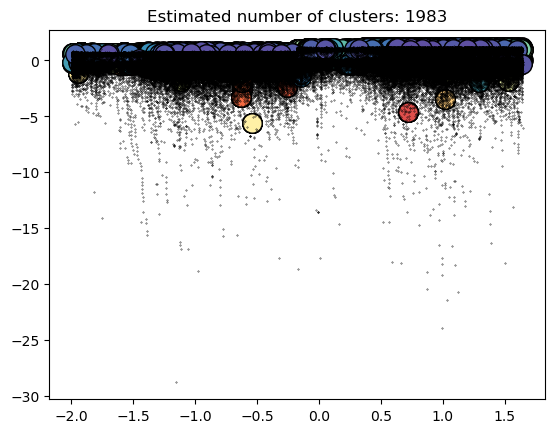

In [44]:
import matplotlib.pyplot as plt

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X_train_scaled[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X_train_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=.3,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

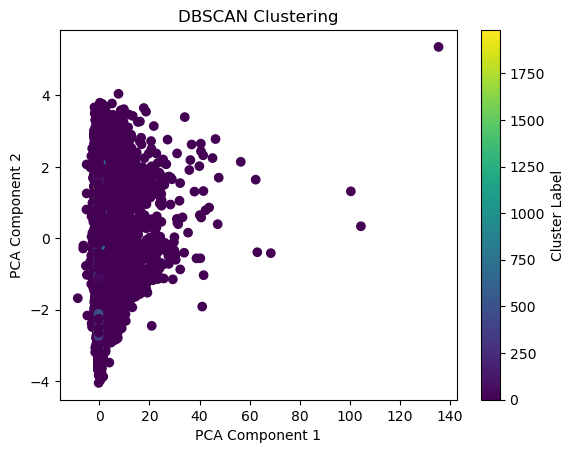

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_train_scaled)

plt.scatter(pca_data[:, 0], pca_data[:, 1],
            c=labels,
            cmap='viridis',
            marker='o')

plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')

plt.show()

## Optimization / Hyperparameterization

| Hyperparameter | Description |
|----------------|-------------|
| `eps`          | The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function. |
| `min_samples` | The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse. |

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'eps': [0.1, 0.3, 0.5, 0.8, 1, 1.5, 2],
    'min_samples': [5, 10, 50, 100]
}

# Initialize the grid search
grid_search = GridSearchCV(dbscan, 
                           param_grid,
                           scoring = 'adjusted_rand_score', 
                           cv=3)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

/home/dshebb/miniconda3/envs/dsh-venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dshebb/miniconda3/envs/dsh-venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/dsh-venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dshebb/miniconda3/envs/dsh-venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^

Best parameters: {'eps': 0.1, 'min_samples': 5}
